### Climate Policymaking : a decision-making problem about CO2 mitigation

dapted from EMA Workbench Lakeproblem Example

The Climate Change Problem forms a hypothetical scenario where the global community makes the decision on the amount of annual CO2 emissions to be released. The challenge is, if the CO2 concentration in the atmosphere surpasses a certain critical threshold or a "tipping point", it may cause irreversible and dangerous changes to the global climate system.

The Climate Change model has 4 **outcome indicators**:

1. **CO2_concentration**: The average concentration of CO2 in the atmosphere over a given timeframe, which we aim to minimize.

2. **economic_welfare**: The economic benefits derived from emitting CO2 minus the costs of having excessive CO2 in the atmosphere, which we aim to maximize.

3. **emission_inertia**: Inertia is maximized by setting an annual reduction limit on emissions, thereby preventing rapid declines in emissions that would require massive investments, and measured by the fraction of years where emission reductions stay below the set limit.

4. **reliability**: The fraction of years when the CO2 concentration in the atmosphere is below the critical threshold, which we aim to maximize to prevent triggering dangerous climate disruptions.

The Climate Change Problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural emissions of CO2. In order to reduce this form of uncertainty, multiple replications are performed, and the average over these replications is taken. Deep uncertainty involves uncertainty about the mean and standard deviation of the log-normal distribution representing natural emissions, Earth's natural CO2 absorption rate, the natural emission rate of CO2, and the discount rate. Based on scientific understanding, ranges for these deeply uncertain factors can be established, as well as their best estimate or default values.

|Parameter	|Range	        |Default value| Description |
|-----------|--------------:|------------:|---------------------------:|
|$\mu$    	|0.01 – 0.05	|0.02         | Mean of the log-normal distribution representing the natural variability in CO2 emissions |
|$\sigma$	|0.001 – 0.005 	|0.0017       | Standard deviation of the log-normal distribution representing the natural variability in CO2 emissions |
|$b$      	|0.1 – 0.45	    |0.42         | Earth’s natural CO2 absorption rate, representing the rate at which CO2 is removed from the atmosphere |
|$q$	    |2 – 4.5	    |2            | Represents a decay rate in the concentration of CO2 in the atmosphere due to oceanic absorption |
|$\delta$	|0.93 – 0.99	|0.98         | Discount rate for the economic welfare calculation, indicating the decrease in future benefits compared to present benefits |

we apply a more sophisticated strategy to the problem of climate change. We employ a **closed-loop** version of the model, which means that anthropogenic emissions, represented as $a_t$, is dependent on $X_t$ (the CO2 concentration in the atmosphere at time t). For instance, we can lowerCO2 emissions when approaching the critical threshold. Using "cubic radial basis functions", following Quinn et al. 2017 we formulate $a_t$ as follows: (Please note that the formulation of $a_t$ will depend on the policy and decision mechanisms introduced, which could include a range of tools from emission tax, cap-and-trade schemes to regulations).


\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the emissions strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

In [3]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
#from optimization_lake_model_dps import lake_problem
from model.simple_climate_economy_model import climate_policy_model
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
ema_logging.log_to_stderr(ema_logging.INFO)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model = Model("climatepolicymodel", function=climate_policy_model)

# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_CO2"),
    ScalarOutcome("economic_welfare"),
    ScalarOutcome("emission_inertia"),
    ScalarOutcome("reliability"),
]

#TODO remove this later
# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]




In [4]:

# The n_processes=-1 ensures that all cores except 1 are used, which is kept free to keep using the computer
with MultiprocessingEvaluator(model) as evaluator:
    # Run 1000 scenarios for 5 policies
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=10)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 10 policies * 1 model(s) = 10000 experiments
100%|███████████████████████████████████| 10000/10000 [00:41<00:00, 242.54it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] no time dimension found in results


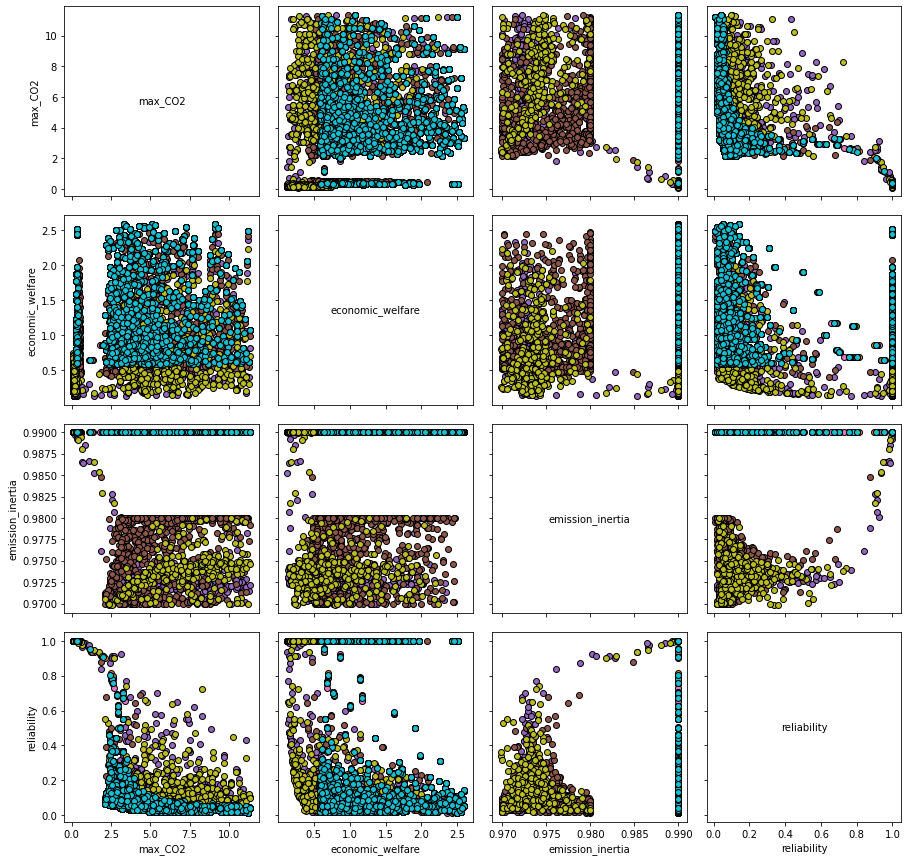

In [7]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy", legend=False)
fig.set_size_inches(15, 15)
plt.show()

In [8]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench.em_framework.evaluators import BaseEvaluator


# specify outcomes
model.outcomes = [
    ScalarOutcome("max_CO2", ScalarOutcome.MINIMIZE),
    ScalarOutcome("economic_welfare", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("emission_inertia", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", ScalarOutcome.MAXIMIZE),
]

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=5e3, searchover='levers',
                                 epsilons=[0.01,]*len(model.outcomes))

[MainProcess/INFO] pool started with 10 workers
5036it [00:25, 194.70it/s]                                                     
[MainProcess/INFO] optimization completed, found 117 solutions
[MainProcess/INFO] terminating pool


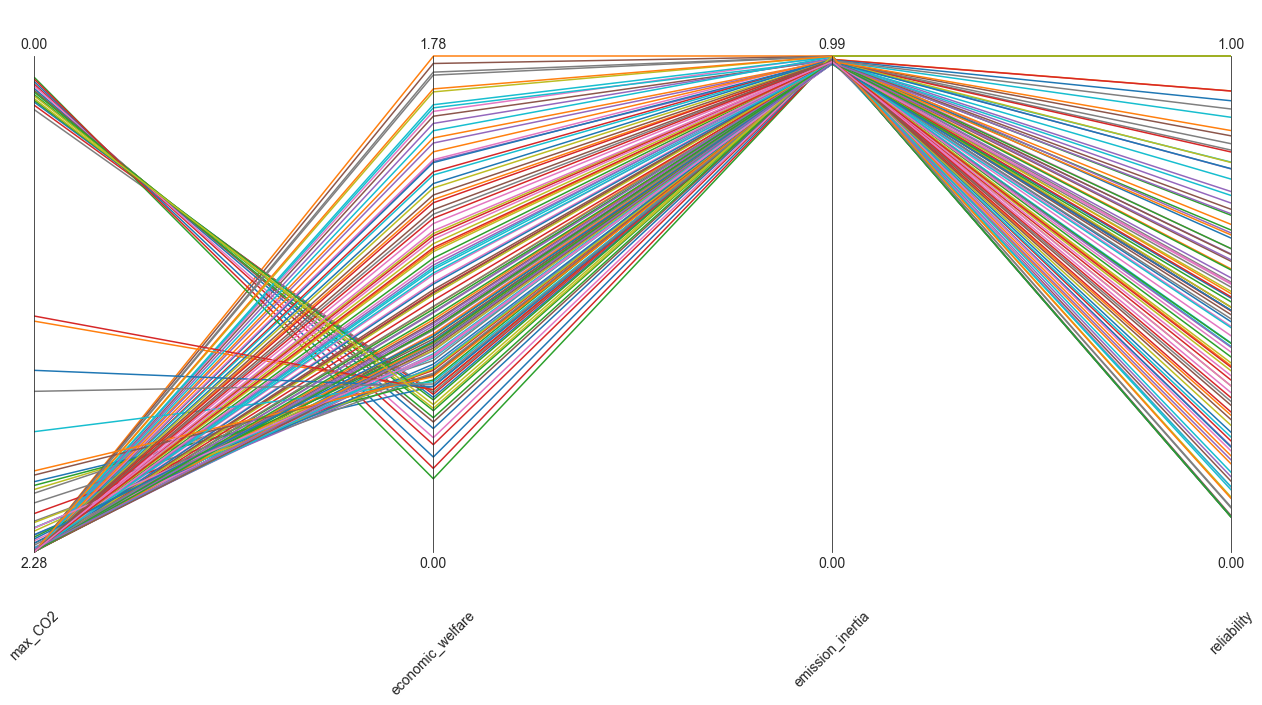

In [17]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['economic_welfare', 'emission_inertia', 'reliability', 'max_CO2']] = 0


paraxes = parcoords.ParallelAxes(limits, rot = 45)
paraxes.plot(data)
paraxes.invert_axis('max_CO2')


# Change the size of the plot
paraxes.fig.set_size_inches(20, 14)

plt.show()

Max_P is negatively correlated with utility and intertia, and positevely with reliability. if we look at inertia, there are two solutions which sacrifice intertia for higher scores on reliability. These might reflect a different correlation structure, or be evidence of incomplete convergence. 


## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**

**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a format that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

There are various ways to do it. One way is to use logical indexing. Basically, create a boolean vector that indicates for each row if the constraint is met or not. Next, we can use this as an index on the dataframe to get only the rows for which the index is true.




In [31]:
logical = (results.reliability > 0.6 ) & (results.max_CO2 < 0.2) & (results.economic_welfare > 0.4)
np.sum(logical)

7

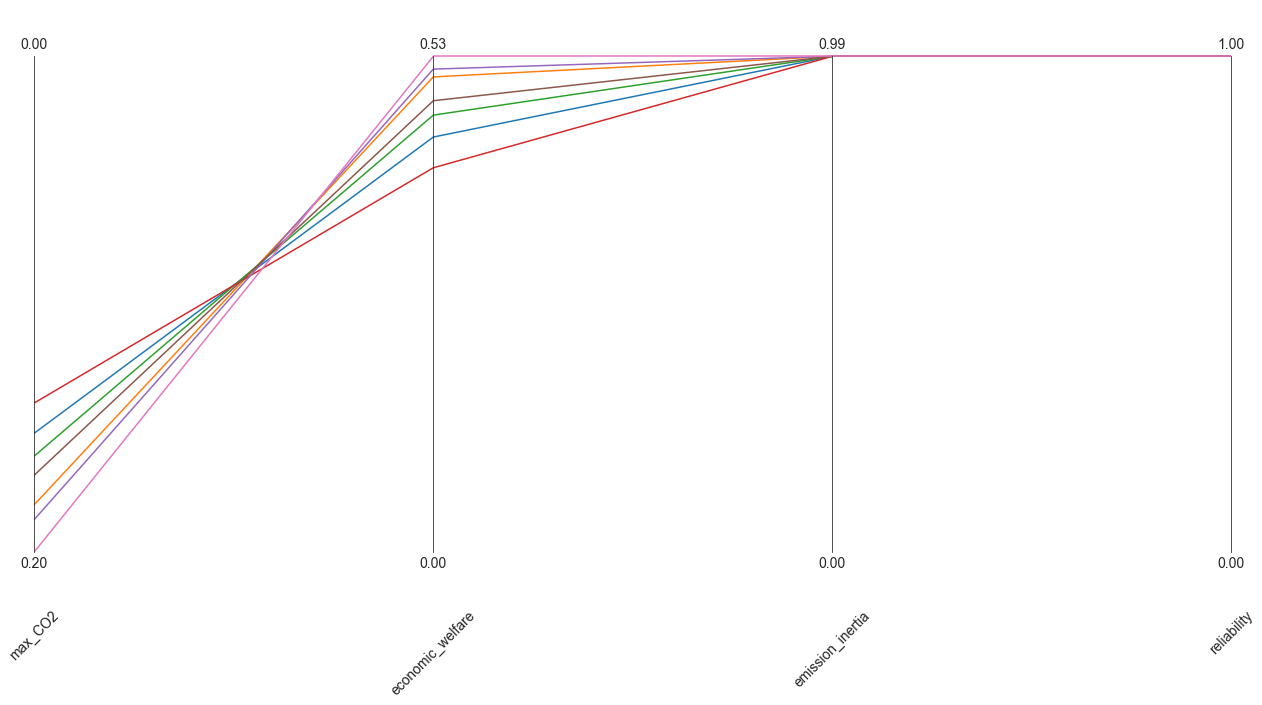

In [35]:
data = results[logical]
data = data.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['economic_welfare', 'emission_inertia', 'reliability', 'max_CO2']] = 0


paraxes = parcoords.ParallelAxes(limits, rot = 45)
paraxes.plot(data)
paraxes.invert_axis('max_CO2')


# Change the size of the plot
paraxes.fig.set_size_inches(20, 14)

In [32]:
results[logical]

,c1,c2,r1,r2,w1,max_CO2,economic_welfare,emission_inertia,reliability
10,0.269268,0.721632,0.479010,1.705247,0.781796,0.148932,0.442227,0.99,1.0
12,0.318577,0.539758,0.490962,1.268976,0.826095,0.177171,0.506374,0.99,1.0
15,0.288507,0.037317,0.432557,1.745693,0.786537,0.157958,0.465607,0.99,1.0
16,0.271839,0.451462,0.490962,1.281866,0.700233,0.136990,0.409466,0.99,1.0
18,0.318893,-0.225349,0.490962,1.272226,0.737865,0.183040,0.514677,0.99,1.0
22,0.616002,0.328833,1.092060,0.653384,0.129755,0.165509,0.480948,0.99,1.0
108,0.453048,-0.124531,0.780008,1.299605,0.489991,0.195817,0.528324,0.99,1.0


In [33]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies

,c1,c2,r1,r2,w1
10,0.269268,0.721632,0.479010,1.705247,0.781796
12,0.318577,0.539758,0.490962,1.268976,0.826095
15,0.288507,0.037317,0.432557,1.745693,0.786537
16,0.271839,0.451462,0.490962,1.281866,0.700233
18,0.318893,-0.225349,0.490962,1.272226,0.737865
22,0.616002,0.328833,1.092060,0.653384,0.129755
108,0.453048,-0.124531,0.780008,1.299605,0.489991
